In [448]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

In [449]:
# Grab and process the raw data.
snt_train = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)
snt_train.columns = ['sentance', 'score']

In [450]:
# collect the words from positive and negative reviews
words_pos = re.findall('\w+', ' '.join(snt_train[snt_train['score'] == 1].sentance.tolist()).lower())
words_neg = re.findall('\w+', ' '.join(snt_train[snt_train['score'] == 0].sentance.tolist()).lower())

# remove words that are in both lists
words_pos_unique = [x for x in words_pos if x not in words_neg]
words_neg_unique = [x for x in words_neg if x not in words_pos]


In [451]:
# some of the top 20 positive words are directly related to the product (i.e. cases
# keyboard, leather).  This model will be used for other products so these 
# words should be removed so that we have a generic top 10
Counter(words_pos_unique).most_common(20)

[('nice', 22),
 ('love', 20),
 ('perfectly', 6),
 ('value', 5),
 ('sturdy', 5),
 ('definitely', 5),
 ('free', 5),
 ('pleased', 5),
 ('charm', 5),
 ('awesome', 5),
 ('overall', 5),
 ('range', 5),
 ('cases', 5),
 ('seems', 4),
 ('keyboard', 4),
 ('order', 4),
 ('leather', 4),
 ('fast', 4),
 ('comfortably', 4),
 ('glad', 4)]

In [452]:
# after reviewing the positive words, remove the highest occurring words that refer to the product specifically 
words_pos_prod_specific = ['sturdy','free','charm','range','cases','keyboard','order','leather','fast','comfortably']
words_pos_unique_generic=[x for x in words_pos_unique if x not in words_pos_prod_specific]

In [453]:
# some of the top 20 negative words are directly related to the product (i.e. cases
# keyboard, leather).  This model will be used for other products so these 
# words should be removed so that we have a generic top 10
Counter(words_neg_unique).most_common(20)

[('poor', 15),
 ('waste', 14),
 ('bad', 14),
 ('worst', 14),
 ('disappointed', 10),
 ('terrible', 10),
 ('broke', 8),
 ('horrible', 8),
 ('junk', 8),
 ('unit', 8),
 ('didn', 7),
 ('useless', 7),
 ('stay', 6),
 ('crap', 6),
 ('difficult', 6),
 ('week', 5),
 ('disappointment', 5),
 ('return', 5),
 ('old', 5),
 ('anything', 5)]

In [454]:
# after reviewing the negative words, remove the highest occurring words that refer to the product specifically 
words_neg_prod_specific = ['broke','junk','unit','stay']
words_neg_unique_generic=[x for x in words_neg_unique if x not in words_neg_prod_specific]

In [455]:
# collect the top 10 words from the positive and negative reviews
words_pos_unique_generic_top10 = Counter(words_pos_unique_generic).most_common(10)
words_neg_unique_generic_top10 = Counter(words_neg_unique_generic).most_common(10)

In [456]:
feats_p = pd.DataFrame()

for key in words_pos_unique_generic_top10:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    feats_p['p_'+str(key[0])] = snt_train.sentance.str.contains(
        ' ' + key[0] + ' ',
        case=False
    )

In [457]:
feats_p.head()

,p_nice,p_love,p_perfectly,p_value,p_definitely,p_pleased,p_awesome,p_overall,p_seems,p_glad
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


In [458]:
snt_train.head()

,sentance,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [459]:
feats_n = pd.DataFrame()

for key in words_neg_unique_generic_top10:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    feats_n['n_'+str(key[0])] = snt_train.sentance.str.contains(
        key[0],
        case=False
    )  

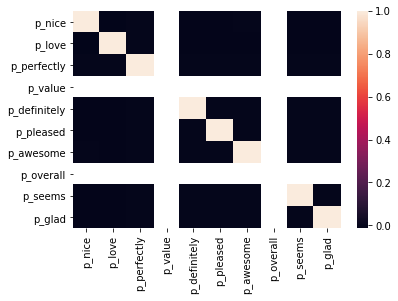

In [460]:
sns.heatmap(feats_p.corr())

In [461]:
#"value" and "overall" very highly correlated, dropping value as it's least represented base on order of pos values
feats_p_uncorr = feats_p.drop(['p_overall','p_value'], axis=1)

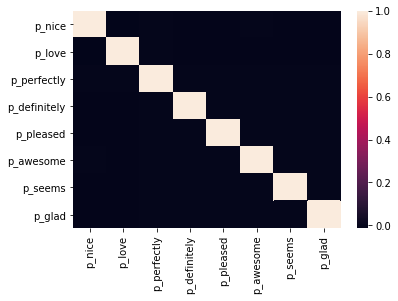

In [462]:
sns.heatmap(feats_p_uncorr.corr())

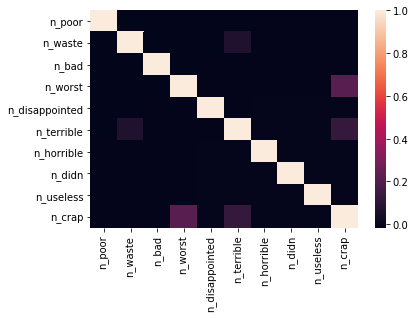

In [463]:
sns.heatmap(feats_n.corr())

In [464]:
# No negative features were correlated so not dropping any
feats_n_uncorr = feats_n

### Explanation

The presence of one of the positvie feature words in the statement (indicated by "TRUE" in "feats_p_uncorr") independently (the words are not correlated) contribute to the probability that the statement is positive.

In [465]:
# Bernoulli classifier
def BnbClassifier (data, target):
    # Our data is binary / boolean, so we're importing the Bernoulli classifier.
    from sklearn.naive_bayes import BernoulliNB

    # Instantiate our model and store it in a new variable.
    bnb = BernoulliNB()

    # Fit our model to the data.
    bnb.fit(data, target)
    
    y_pred = bnb.predict(data)

    return y_pred,bnb

In [466]:
# Bernoulli classifier
def MnbClassifier (data, target):
    # importing the Multinomial classifier.
    from sklearn.naive_bayes import MultinomialNB
    
    mnb = MultinomialNB()
    mnb.fit(data, target)
    y_pred = mnb.predict(data)

    return y_pred,bnb

In [467]:
# Display our results.
def DisplayResults(data, y_pred):
    print("\nRESULTS:\n")
    print("Number of mislabeled points out of a total {} points : {}".format(
        data.shape[0],
        (target != y_pred).sum()
    ))

In [479]:
# confusion matrix
def ConfusionMatrix(target, y_pred):
    df_confusion = pd.crosstab(target, y_pred, rownames=['Actual'], colnames=['Predicted'])
    
    print ('\nCONFUSION MATRIX:\n ')
    print (df_confusion)

    print ('\nwhen a message was pos and we predicted pos: ', df_confusion[1][1])
    print ('when a message was pos and we predicted neg: ', df_confusion[0][1])
    print ('when a message was neg and we predicted neg: ',df_confusion[0][0])
    print ('when a message was neg and we predicted pos: ',df_confusion[1][0])

    total_pos = df_confusion[0][1] + df_confusion[1][1]
    correct_pos = df_confusion[1][1]
    total_neg = df_confusion[0][0] + df_confusion[1][0]
    correct_neg = df_confusion[0][0]
    sensitivity = (correct_pos/total_pos)*100
    specificity = (correct_neg/total_neg)*100

    print('\ntotal positives = ', total_pos)
    print('correct positives = ', correct_pos)
    print('sensitivity = ',sensitivity,'%')
    print('\ntotal negatives = ', total_neg)
    print('correct negatives = ', correct_neg)
    print('specificity = ',specificity,'%')

In [480]:
# cross validation
def CrossValidation(bnb, data, target):
    print ('\nCROSS VALIDATION:')
    from sklearn.model_selection import cross_val_score
    print (cross_val_score(bnb, data, target, cv=10))

In [481]:
def BnbComplete(data, target):
    y_pred,bnb = BnbClassifier (data, target)
    DisplayResults(data, y_pred)
    ConfusionMatrix(target, y_pred)
    CrossValidation(bnb, data, target)
    return y_pred

In [482]:
def MnbComplete(data, target):
    y_pred,mnb = MnbClassifier (data, target)
    DisplayResults(data, y_pred)
    ConfusionMatrix(target, y_pred)
    CrossValidation(mnb, data, target)
    return y_pred

In [483]:
feats_n_uncorr.head()

,n_poor,n_waste,n_bad,n_worst,n_disappointed,n_terrible,n_horrible,n_didn,n_useless,n_crap
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


In [485]:
target = snt_train['score']
data = feats_n_uncorr
y_pred = BnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 397

CONFUSION MATRIX:
 
Predicted    0    1
Actual             
0          103  397
1            0  500

when a message was pos and we predicted pos:  500
when a message was pos and we predicted neg:  0
when a message was neg and we predicted neg:  103
when a message was neg and we predicted pos:  397

total positives =  500
correct positives =  500
sensitivity =  100.0 %

total negatives =  500
correct negatives =  103
specificity =  20.6 %

CROSS VALIDATION:
[ 0.6   0.61  0.65  0.62  0.59  0.61  0.59  0.54  0.63  0.59]


In [474]:
feats_p_uncorr.head()

,p_nice,p_love,p_perfectly,p_definitely,p_pleased,p_awesome,p_seems,p_glad
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False


In [505]:
target = snt_train['score']
data = feats_p_uncorr
y_pred = BnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 456

CONFUSION MATRIX:
 
Predicted    0   1
Actual            
0          500   0
1          456  44

when a message was pos and we predicted pos:  44
when a message was pos and we predicted neg:  456
when a message was neg and we predicted neg:  500
when a message was neg and we predicted pos:  0

total positives =  500
correct positives =  44
sensitivity =  8.8 %

total negatives =  500
correct negatives =  500
specificity =  100.0 %

CROSS VALIDATION:
[ 0.54  0.58  0.55  0.54  0.53  0.56  0.54  0.52  0.53  0.52]


In [506]:
feats_pn_uncorr = pd.concat([feats_p_uncorr, feats_n_uncorr], axis=1)
feats_pn_uncorr.head()

,p_nice,p_love,p_perfectly,p_definitely,p_pleased,p_awesome,p_seems,p_glad,n_poor,n_waste,n_bad,n_worst,n_disappointed,n_terrible,n_horrible,n_didn,n_useless,n_crap
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [507]:
target = snt_train['score']
data = feats_pn_uncorr
y_pred = BnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 397

CONFUSION MATRIX:
 
Predicted    0    1
Actual             
0          103  397
1            0  500

when a message was pos and we predicted pos:  500
when a message was pos and we predicted neg:  0
when a message was neg and we predicted neg:  103
when a message was neg and we predicted pos:  397

total positives =  500
correct positives =  500
sensitivity =  100.0 %

total negatives =  500
correct negatives =  103
specificity =  20.6 %

CROSS VALIDATION:
[ 0.6   0.61  0.65  0.62  0.59  0.61  0.59  0.54  0.63  0.59]


### Model is over predicting positive reviews

Review the negative reviews that were predicted positive to see if there are any additional features that could be added.

In [516]:
# collect sentences, actual score, and predicted
snt_train_pred = snt_train
snt_train_pred['pred'] = y_pred

In [518]:
# collect negative reviews that were predicted positive
snt_train_pred_s0_p1 = snt_train_pred[(snt_train_pred['score']==0) & (snt_train_pred['pred']==1)]

In [520]:
# get all of the words from these reviews
snt_raw_pred_s0_p1_words = re.findall('\w+', ' '.join(snt_train_pred_s0_p1.sentance.tolist()).lower())

In [521]:
# collect words that have not already been used in neg word feature
snt_raw_pred_s0_p1_words_new = [x for x in snt_raw_pred_s0_p1_words if x not in words_neg_unique_generic_top10]

In [536]:
# list the most common
Counter(snt_raw_pred_s0_p1_words_new).most_common(10)

[('the', 243),
 ('i', 165),
 ('it', 146),
 ('and', 107),
 ('to', 96),
 ('not', 96),
 ('a', 93),
 ('this', 88),
 ('is', 81),
 ('phone', 69)]

In [537]:
# collect positive reviews that were predicted positive
snt_train_pred_s1_p1 = snt_train_pred[(snt_train_pred['score']==1) & (snt_train_pred['pred']==1)]
# get all of the words from these reviews
snt_raw_pred_s1_p1_words = re.findall('\w+', ' '.join(snt_train_pred_s1_p1.sentance.tolist()).lower())
# collect words that have not already been used in neg word feature
snt_raw_pred_s1_p1_words_new = [x for x in snt_raw_pred_s1_p1_words if x not in words_neg_unique_generic_top10]

Counter(snt_raw_pred_s1_p1_words_new).most_common(10)

[('the', 239),
 ('and', 189),
 ('i', 186),
 ('it', 145),
 ('is', 141),
 ('a', 106),
 ('this', 105),
 ('great', 94),
 ('phone', 88),
 ('to', 87)]

In [531]:
# "not" seems to be in many of the top negative reviews but not in the top positive reviews
# so adding as a new feature
feats_pn_plus_n = feats_pn_uncorr
feats_pn_plus_n['n_not'] = snt_train.sentance.str.contains(' not ',case=False)

In [533]:
target = snt_train['score']
data = feats_pn_plus_n
y_pred = BnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 331

CONFUSION MATRIX:
 
Predicted    0    1
Actual             
0          181  319
1           12  488

when a message was pos and we predicted pos:  488
when a message was pos and we predicted neg:  12
when a message was neg and we predicted neg:  181
when a message was neg and we predicted pos:  319

total positives =  500
correct positives =  488
sensitivity =  97.6 %

total negatives =  500
correct negatives =  181
specificity =  36.2 %

CROSS VALIDATION:
[ 0.65  0.72  0.72  0.67  0.66  0.63  0.7   0.6   0.7   0.64]


In [538]:
# create features based on pos or neg word count
feats_pn_count=pd.DataFrame()
poslabels=[column for column in feats_pn_uncorr.columns if column.startswith('p_')]
feats_pn_count['poslabels'] = feats_pn_uncorr[poslabels].sum(axis=1)

neglabels=[column for column in feats_pn_uncorr.columns if column.startswith('n_')]
feats_pn_count['neglabels'] = feats_pn_uncorr[neglabels].sum(axis=1)

In [539]:
feats_pn_count.head()

,poslabels,neglabels
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [541]:
target = snt_train['score']
data = feats_pn_count
y_pred = MnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 456

CONFUSION MATRIX:
 
Predicted    0   1
Actual            
0          500   0
1          456  44

when a message was pos and we predicted pos:  44
when a message was pos and we predicted neg:  456
when a message was neg and we predicted neg:  500
when a message was neg and we predicted pos:  0

total positives =  500
correct positives =  44
sensitivity =  8.8 %

total negatives =  500
correct negatives =  500
specificity =  100.0 %

CROSS VALIDATION:
[ 0.65  0.72  0.72  0.69  0.66  0.63  0.7   0.6   0.7   0.64]


In [543]:
[column for column in feats_pn_uncorr]

['p_nice',
 'p_love',
 'p_perfectly',
 'p_definitely',
 'p_pleased',
 'p_awesome',
 'p_seems',
 'p_glad',
 'n_poor',
 'n_waste',
 'n_bad',
 'n_worst',
 'n_disappointed',
 'n_terrible',
 'n_horrible',
 'n_didn',
 'n_useless',
 'n_crap',
 'n_not']

### Model is over predicting negative reviews

Even out the number of columns for pos and neg.

In [549]:
#>>> df.drop(['B', 'C'], axis=1)

feats_pn_even = feats_pn_uncorr.drop(['n_crap', 'n_useless', 'n_didn','n_horrible'], axis=1)
feats_pn_even.head()

,p_nice,p_love,p_perfectly,p_definitely,p_pleased,p_awesome,p_seems,p_glad,n_poor,n_waste,n_bad,n_worst,n_disappointed,n_terrible,n_not
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [548]:
target = snt_train['score']
data = feats_pn_even
y_pred = MnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 456

CONFUSION MATRIX:
 
Predicted    0   1
Actual            
0          500   0
1          456  44

when a message was pos and we predicted pos:  44
when a message was pos and we predicted neg:  456
when a message was neg and we predicted neg:  500
when a message was neg and we predicted pos:  0

total positives =  500
correct positives =  44
sensitivity =  8.8 %

total negatives =  500
correct negatives =  500
specificity =  100.0 %

CROSS VALIDATION:
[ 0.64  0.71  0.68  0.66  0.63  0.62  0.68  0.58  0.67  0.62]


In [550]:
feats_pn_skew_n = feats_pn_even.drop(['n_not'], axis=1)
feats_pn_skew_n.head()

,p_nice,p_love,p_perfectly,p_definitely,p_pleased,p_awesome,p_seems,p_glad,n_poor,n_waste,n_bad,n_worst,n_disappointed,n_terrible
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [551]:
target = snt_train['score']
data = feats_pn_skew_n
y_pred = MnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 456

CONFUSION MATRIX:
 
Predicted    0   1
Actual            
0          500   0
1          456  44

when a message was pos and we predicted pos:  44
when a message was pos and we predicted neg:  456
when a message was neg and we predicted neg:  500
when a message was neg and we predicted pos:  0

total positives =  500
correct positives =  44
sensitivity =  8.8 %

total negatives =  500
correct negatives =  500
specificity =  100.0 %

CROSS VALIDATION:
[ 0.59  0.6   0.61  0.6   0.56  0.6   0.57  0.51  0.59  0.56]


In [553]:
feats_pn_hvy_skew_n = feats_pn_skew_n.drop(['n_terrible','n_disappointed'], axis=1)
feats_pn_hvy_skew_n.head()

,p_nice,p_love,p_perfectly,p_definitely,p_pleased,p_awesome,p_seems,p_glad,n_poor,n_waste,n_bad,n_worst
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False


In [555]:
target = snt_train['score']
data = feats_pn_hvy_skew_n
y_pred = MnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 456

CONFUSION MATRIX:
 
Predicted    0   1
Actual            
0          500   0
1          456  44

when a message was pos and we predicted pos:  44
when a message was pos and we predicted neg:  456
when a message was neg and we predicted neg:  500
when a message was neg and we predicted pos:  0

total positives =  500
correct positives =  44
sensitivity =  8.8 %

total negatives =  500
correct negatives =  500
specificity =  100.0 %

CROSS VALIDATION:
[ 0.56  0.59  0.59  0.59  0.54  0.58  0.54  0.51  0.57  0.53]


### Test Set

In [556]:
# Grab and process the raw data.
snt_test = pd.read_csv("yelp_labelled.txt", delimiter='\t', header=None)
snt_test.columns = ['sentance', 'score']

In [ ]:
feats_p = pd.DataFrame()

for key in words_pos_unique_generic_top10:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    feats_p['p_'+str(key[0])] = snt_test.sentance.str.contains(
        ' ' + key[0] + ' ',
        case=False
    )

In [ ]:
feats_n = pd.DataFrame()

for key in words_neg_unique_generic_top10:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    feats_n['n_'+str(key[0])] = snt_test.sentance.str.contains(
        key[0],
        case=False
    ) 

In [ ]:
feats_n = pd.DataFrame()

for key in words_neg_unique_generic_top10:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    feats_n['n_'+str(key[0])] = snt_train.sentance.str.contains(
        key[0],
        case=False
    ) 

In [ ]:
snt_train_pred_feat = snt_train_pred.join(feats_pn_uncorr)
snt_train_pred_s0_p1 = snt_train_pred_feat[(snt_train_pred_feat['score']==0) & (snt_train_pred_feat['pred']==1)]

,sentance,score,pred,p_nice,p_love,p_perfectly,p_definitely,p_pleased,p_awesome,p_seems,...,n_poor,n_waste,n_bad,n_worst,n_disappointed,n_terrible,n_horrible,n_didn,n_useless,n_crap
0,So there is no way for me to plug it in here i...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Tied to charger for conversations lasting more...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,I have to jiggle the plug to get it to line up...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,If you have several dozen or several hundred c...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12,If the two were seperated by a mere 5+ ft I st...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14,"The design is very odd, as the ear ""clip"" is n...",0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16,I advise EVERYONE DO NOT BE FOOLED!,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19,It clicks into place in a way that makes you w...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20,I went on Motorola's website and followed all ...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
22,The commercials are the most misleading.,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [422]:
feats_pn_count=pd.DataFrame()
poslabels=[column for column in feats_pn_uncorr.columns if column.startswith('p_')]
feats_pn_count['poslabels'] = feats_pn_uncorr[poslabels].sum(axis=1)

In [423]:
neglabels=[column for column in feats_pn_uncorr.columns if column.startswith('n_')]
feats_pn_count['neglabels'] = feats_pn_uncorr[neglabels].sum(axis=1)

In [424]:
feats_pn_count.head()

,poslabels,neglabels
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [425]:
target = snt_raw['score']
data = feats_pn_count
MnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 456

CONFUSION MATRIX:
 
Predicted    0   1
Actual            
0          500   0
1          456  44

when a message was pos and we predicted pos:  44
when a message was pos and we predicted neg:  456
when a message was neg and we predicted neg:  500
when a message was neg and we predicted pos:  0

total positives =  500
correct positives =  44
sensitivity =  8.8 %

total negatives =  500
correct negatives =  500
specificity =  100.0 %

CROSS VALIDATION:
[ 0.6   0.61  0.65  0.62  0.59  0.61  0.59  0.54  0.63  0.59]


In [304]:
target = (snt_raw['score'] == 0)
data = feats_n_uncorr

In [305]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [306]:
# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

In [307]:
DisplayResults(data, y_pred)

Number of mislabeled points out of a total 1000 points : 397


In [308]:
# Grab and process the raw data.
#snt_raw = pd.read_csv("yelp_labelled.txt", delimiter='\t', header=None)
#snt_raw.columns = ['sentance', 'score']

In [371]:
target = (snt_raw['score'] == 1)
data = feats_p_uncorr

In [372]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [373]:
# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

In [374]:
DisplayResults(data, y_pred)


RESULTS:

Number of mislabeled points out of a total 1000 points : 456


In [375]:
ConfusionMatrix(target, y_pred)


CONFUSION MATRIX:
 
Predicted  False  True 
Actual                 
False        500      0
True         456     44

when a message was pos and we predicted pos:  44
when a message was pos and we predicted neg:  456
when a message was neg and we predicted neg:  500
when a message was neg and we predicted pos:  0

total positives =  500
correct positives =  44
sensitivity =  8.8 %

total negatives =  500
correct negatives =  500
specificity =  100.0 %


In [376]:
y_pred = BnbClassifier(data,target)
DisplayResults(data, y_pred)
ConfusionMatrix(target, y_pred)


RESULTS:

Number of mislabeled points out of a total 1000 points : 456

CONFUSION MATRIX:
 
Predicted  False  True 
Actual                 
False        500      0
True         456     44

when a message was pos and we predicted pos:  44
when a message was pos and we predicted neg:  456
when a message was neg and we predicted neg:  500
when a message was neg and we predicted pos:  0

total positives =  500
correct positives =  44
sensitivity =  8.8 %

total negatives =  500
correct negatives =  500
specificity =  100.0 %


In [397]:
BnbComplete(data,target)


RESULTS:

Number of mislabeled points out of a total 1000 points : 456

CONFUSION MATRIX:
 
Predicted  False  True 
Actual                 
False        500      0
True         456     44

when a message was pos and we predicted pos:  44
when a message was pos and we predicted neg:  456
when a message was neg and we predicted neg:  500
when a message was neg and we predicted pos:  0

total positives =  500
correct positives =  44
sensitivity =  8.8 %

total negatives =  500
correct negatives =  500
specificity =  100.0 %

CROSS VALIDATION:
[ 0.54  0.58  0.55  0.54  0.53  0.56  0.54  0.52  0.53  0.52]


### Explanation

The presence of one of the negative feature words in the statement (indicated by "TRUE" in "feats_n_uncorr") independently (the words are not correlated) contribute to the probability that the statement is negative.

In [314]:
feats_n_uncorr.head()

,n_poor,n_waste,n_bad,n_worst,n_disappointed,n_terrible,n_horrible,n_didn,n_useless,n_crap
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


In [315]:
feats_p_uncorr.head()

,p_nice,p_love,p_perfectly,p_definitely,p_pleased,p_awesome,p_seems,p_glad
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False


In [316]:
ConfusionMatrix(target, y_pred)

Predicted  False  True 
Actual                 
False        500      0
True         456     44

when a message was pos and we predicted pos:  44
when a message was pos and we predicted neg:  456
when a message was neg and we predicted neg:  500
when a message was neg and we predicted pos:  0

total positives =  500
correct positives =  44
sensitivity =  8.8 %

total negatives =  500
correct negatives =  500
specificity =  100.0 %


# Positive and Negative Features Combined

In [317]:
feats_pn_uncorr = pd.concat([feats_p_uncorr, feats_n_uncorr], axis=1)

In [318]:
feats_pn_uncorr.head()

,p_nice,p_love,p_perfectly,p_definitely,p_pleased,p_awesome,p_seems,p_glad,n_poor,n_waste,n_bad,n_worst,n_disappointed,n_terrible,n_horrible,n_didn,n_useless,n_crap
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [319]:
target = snt_raw['score']
data = feats_n_uncorr

In [320]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [321]:
# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

In [322]:
DisplayResults(data, y_pred)

Number of mislabeled points out of a total 1000 points : 397


In [323]:
ConfusionMatrix(target,y_pred)

Predicted    0    1
Actual             
0          103  397
1            0  500

when a message was pos and we predicted pos:  500
when a message was pos and we predicted neg:  0
when a message was neg and we predicted neg:  103
when a message was neg and we predicted pos:  397

total positives =  500
correct positives =  500
sensitivity =  100.0 %

total negatives =  500
correct negatives =  103
specificity =  20.6 %


In [349]:
feats_pn_uncorr.head()

,p_nice,p_love,p_perfectly,p_definitely,p_pleased,p_awesome,p_seems,p_glad,n_poor,n_waste,n_bad,n_worst,n_disappointed,n_terrible,n_horrible,n_didn,n_useless,n_crap
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [350]:
poslabels=[column for column in feats_pn_count.columns if column.startswith('p_')]
feats_pn_count['poslabels'] = feats_pn_count[poslabels].sum(axis=1)

In [351]:
feats_pn_count.head()

,p_nice,p_love,p_perfectly,p_definitely,p_pleased,p_awesome,p_seems,p_glad,n_poor,n_waste,...,n_worst,n_disappointed,n_terrible,n_horrible,n_didn,n_useless,n_crap,poslables,neglabels,poslabels
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0


In [352]:
neglabels=[column for column in feats_pn_count.columns if column.startswith('n_')]
feats_pn_count['neglabels'] = feats_pn_count[neglabels].sum(axis=1)

In [353]:
feats_pn_count.head()

,p_nice,p_love,p_perfectly,p_definitely,p_pleased,p_awesome,p_seems,p_glad,n_poor,n_waste,...,n_worst,n_disappointed,n_terrible,n_horrible,n_didn,n_useless,n_crap,poslables,neglabels,poslabels
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0


In [354]:
feats_pn_count[feats_pn_count['poslabels']==1]

,p_nice,p_love,p_perfectly,p_definitely,p_pleased,p_awesome,p_seems,p_glad,n_poor,n_waste,...,n_worst,n_disappointed,n_terrible,n_horrible,n_didn,n_useless,n_crap,poslables,neglabels,poslabels
40,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,1,0,1
48,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,1,0,1
54,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,1,0,1
78,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,1,0,1
105,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,1,0,1
107,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,1,0,1
115,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,1,0,1
122,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,1,0,1
145,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,1,0,1
158,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,1,0,1


[3]


In [329]:
target = snt_raw['score']
data = feats_pn_count

In [330]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [331]:
DisplayResults(data, y_pred)

Number of mislabeled points out of a total 1000 points : 397


In [332]:
ConfusionMatrix(target,y_pred)

Predicted    0    1
Actual             
0          103  397
1            0  500

when a message was pos and we predicted pos:  500
when a message was pos and we predicted neg:  0
when a message was neg and we predicted neg:  103
when a message was neg and we predicted pos:  397

total positives =  500
correct positives =  500
sensitivity =  100.0 %

total negatives =  500
correct negatives =  103
specificity =  20.6 %


In [383]:
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

array([ 0.54,  0.58,  0.55,  0.54,  0.53,  0.56,  0.54,  0.52,  0.53,  0.52])

In [384]:
CrossValidation(bnb, data, target)


CROSS VALIDATION:
[ 0.54  0.58  0.55  0.54  0.53  0.56  0.54  0.52  0.53  0.52]


In [333]:
snt_raw_pred = snt_raw

In [334]:
snt_raw_pred['pred'] = y_pred
snt_raw_pred_feat = snt_raw_pred.join(feats_pn_count)
snt_raw_pred_s0_p1 = snt_raw_pred_feat[(snt_raw_pred_feat['score']==0) & (snt_raw_pred_feat['pred']==1)]

In [337]:
snt_raw_pred_s0_p1

,sentance,score,pred,p_nice,p_love,p_perfectly,p_definitely,p_pleased,p_awesome,p_seems,...,n_bad,n_worst,n_disappointed,n_terrible,n_horrible,n_didn,n_useless,n_crap,poslables,neglabels
0,So there is no way for me to plug it in here i...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
3,Tied to charger for conversations lasting more...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
5,I have to jiggle the plug to get it to line up...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
6,If you have several dozen or several hundred c...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
12,If the two were seperated by a mere 5+ ft I st...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
14,"The design is very odd, as the ear ""clip"" is n...",0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
16,I advise EVERYONE DO NOT BE FOOLED!,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
19,It clicks into place in a way that makes you w...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
20,I went on Motorola's website and followed all ...,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0
22,The commercials are the most misleading.,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,0


In [338]:
snt_raw_pred_s0_p1_words = re.findall('\w+', ' '.join(snt_raw_pred_s0_p1.sentance.tolist()).lower())
Counter(snt_raw_pred_s0_p1_words).most_common(70)

[('the', 243),
 ('i', 165),
 ('it', 146),
 ('and', 107),
 ('to', 96),
 ('not', 96),
 ('a', 93),
 ('this', 88),
 ('is', 81),
 ('phone', 69),
 ('my', 59),
 ('of', 55),
 ('for', 48),
 ('in', 48),
 ('t', 48),
 ('was', 43),
 ('you', 42),
 ('that', 39),
 ('on', 39),
 ('with', 34),
 ('have', 26),
 ('but', 25),
 ('very', 23),
 ('as', 23),
 ('work', 22),
 ('if', 21),
 ('had', 21),
 ('battery', 20),
 ('after', 20),
 ('ear', 18),
 ('all', 18),
 ('use', 18),
 ('product', 18),
 ('does', 18),
 ('don', 18),
 ('me', 17),
 ('s', 17),
 ('are', 17),
 ('out', 17),
 ('be', 16),
 ('first', 16),
 ('then', 15),
 ('one', 15),
 ('from', 15),
 ('at', 15),
 ('do', 15),
 ('only', 15),
 ('so', 14),
 ('no', 14),
 ('headset', 14),
 ('buy', 14),
 ('when', 14),
 ('up', 13),
 ('or', 13),
 ('would', 13),
 ('doesn', 13),
 ('good', 13),
 ('get', 12),
 ('your', 12),
 ('2', 12),
 ('charger', 11),
 ('like', 11),
 ('case', 11),
 ('same', 11),
 ('more', 10),
 ('could', 10),
 ('time', 10),
 ('item', 10),
 ('worked', 10),
 ('stil

In [268]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words)

LookupError: 
**********************************************************************
  Resource 'corpora/stopwords' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/Users/christophersmyth/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

In [269]:
from nltk.corpus import stopwords
s=set(stopwords.words('english'))

txt="a long string of text about him and her"
#print filter(lambda w: not w in s,snt_raw_pred_s0_p1_words.split())

LookupError: 
**********************************************************************
  Resource 'corpora/stopwords' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/Users/christophersmyth/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

In [271]:
Counter(snt_raw_pred_s0_p1_words).most_common(70)

[('the', 251),
 ('i', 209),
 ('and', 154),
 ('was', 145),
 ('to', 123),
 ('a', 116),
 ('not', 90),
 ('it', 84),
 ('t', 74),
 ('of', 67),
 ('is', 61),
 ('this', 61),
 ('for', 60),
 ('food', 60),
 ('we', 53),
 ('place', 47),
 ('in', 46),
 ('be', 42),
 ('that', 41),
 ('but', 40),
 ('my', 39),
 ('at', 38),
 ('back', 37),
 ('service', 37),
 ('had', 32),
 ('like', 29),
 ('so', 29),
 ('have', 29),
 ('were', 28),
 ('with', 28),
 ('here', 28),
 ('very', 27),
 ('go', 26),
 ('there', 25),
 ('they', 24),
 ('you', 23),
 ('are', 23),
 ('would', 22),
 ('no', 22),
 ('on', 22),
 ('will', 22),
 ('good', 21),
 ('never', 21),
 ('don', 21),
 ('s', 19),
 ('if', 19),
 ('ever', 18),
 ('all', 18),
 ('as', 18),
 ('up', 17),
 ('our', 17),
 ('minutes', 17),
 ('time', 16),
 ('again', 16),
 ('from', 16),
 ('just', 15),
 ('only', 15),
 ('your', 15),
 ('bad', 15),
 ('one', 15),
 ('got', 15),
 ('won', 15),
 ('what', 14),
 ('an', 14),
 ('out', 14),
 ('much', 14),
 ('ve', 14),
 ('disappointed', 14),
 ('been', 13),
 ('be

In [ ]:
# collect the words from positive and negative reviews
words_pos = re.findall('\w+', ' '.join(snt_raw[snt_raw['score'] == 1].sentance.tolist()).lower())
words_neg = re.findall('\w+', ' '.join(snt_raw[snt_raw['score'] == 0].sentance.tolist()).lower())

# remove words that are in both lists
words_pos_unique = [x for x in words_pos if x not in words_neg]
words_neg_unique = [x for x in words_neg if x not in words_pos]

In [44]:
# add some more common positive words, great, good, very

In [2]:
# could take target vs y_pred to see where the misabled ones are (Neg pred as pos, )

In [ ]:
# if no negative words, mark as positive review

In [ ]:
# check for features that did not get any true and drop